
🔍 Gatunek: barrel_jellyfish | Zdjęcie: 14.jpg


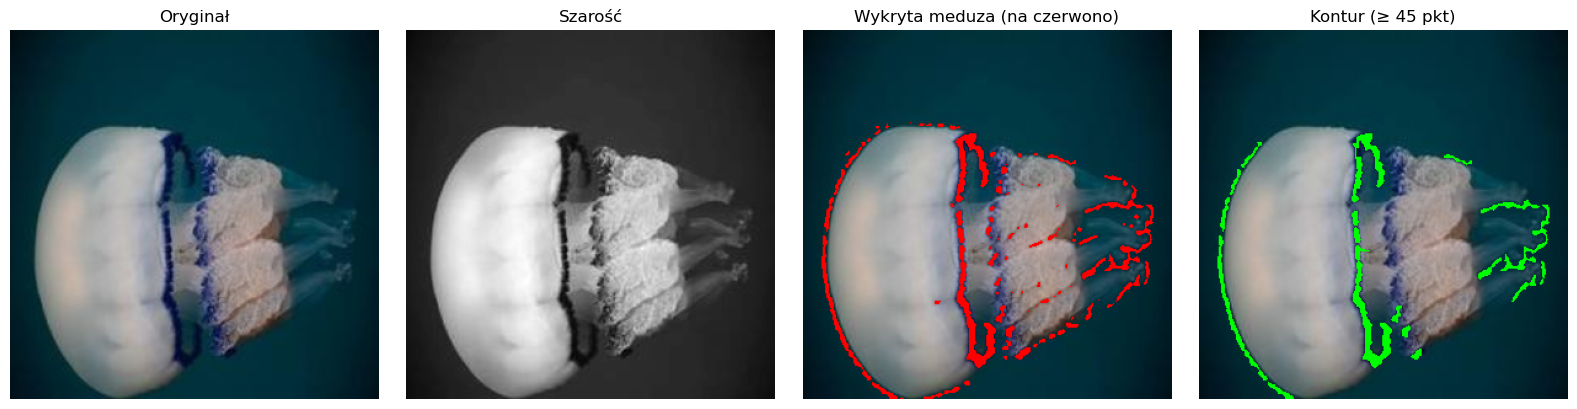


🔍 Gatunek: blue_jellyfish | Zdjęcie: aug-68-21.jpg


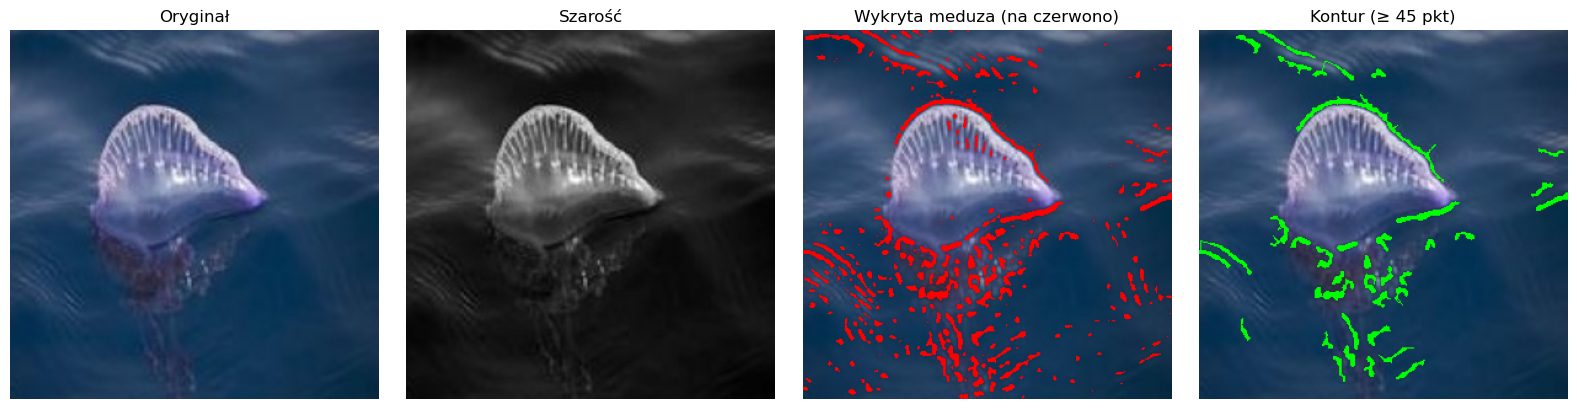


🔍 Gatunek: compass_jellyfish | Zdjęcie: 30.jpg


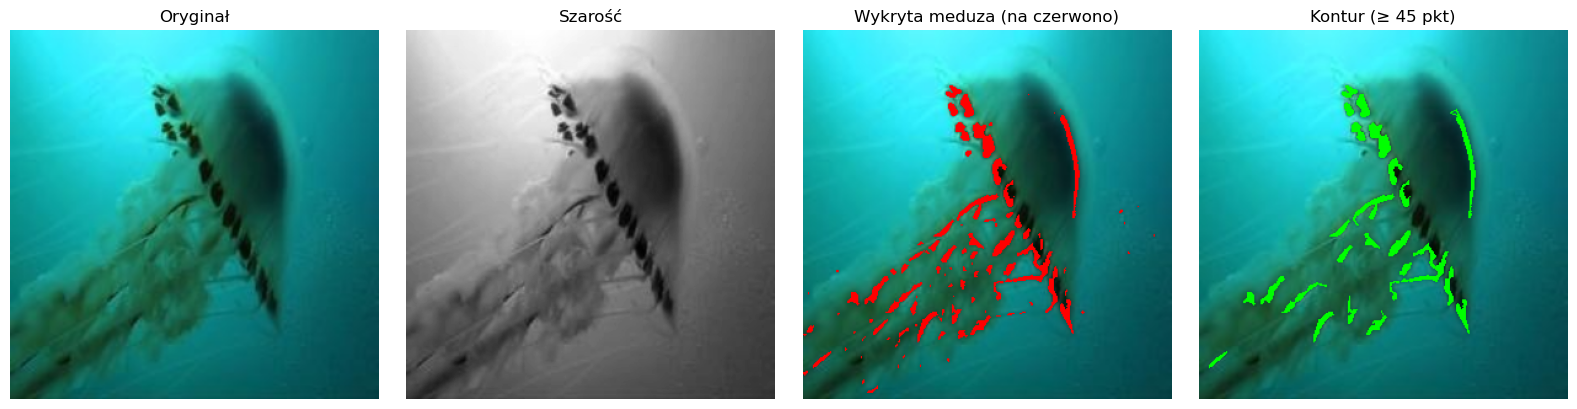


🔍 Gatunek: lions_mane_jellyfish | Zdjęcie: aug-66-06.jpg


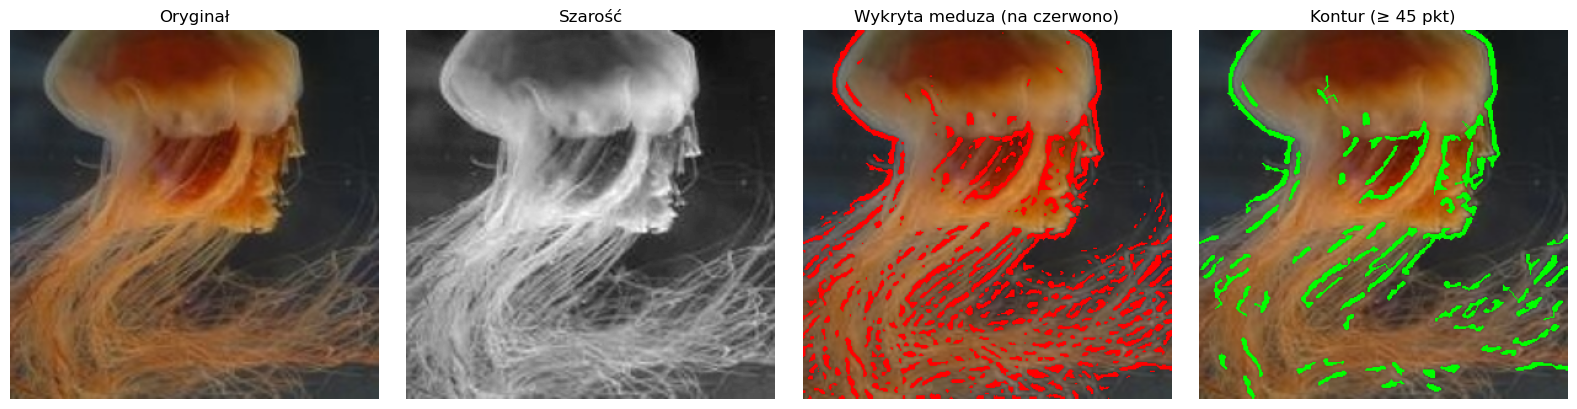


🔍 Gatunek: mauve_stinger_jellyfish | Zdjęcie: aug-67-12.jpg


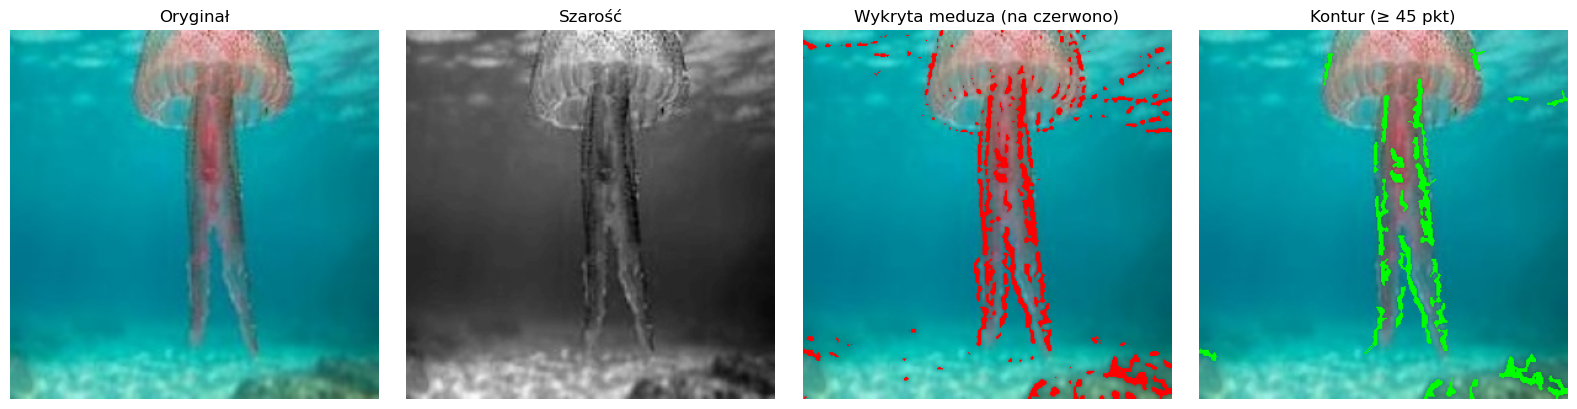


🔍 Gatunek: Moon_jellyfish | Zdjęcie: aug-89-55.jpg


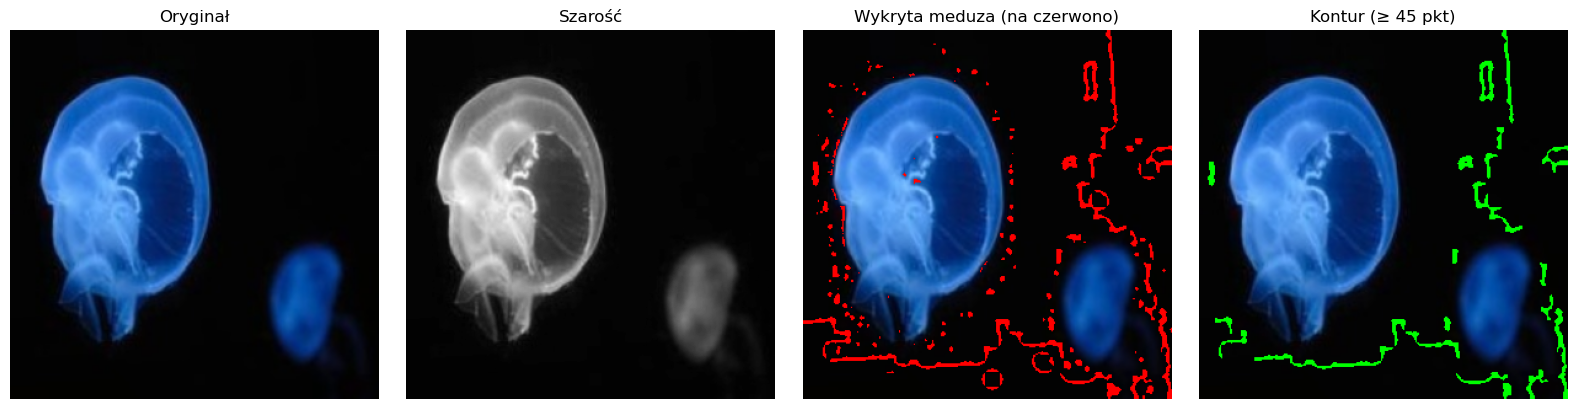

In [38]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Ścieżka do folderu treningowego
BASE_DIR = "DATA/Train_Test_Valid/Train"

# Prawidłowe nazwy folderów z gatunkami meduz
jellyfish_species = [
    "barrel_jellyfish",
    "blue_jellyfish",
    "compass_jellyfish",
    "lions_mane_jellyfish",
    "mauve_stinger_jellyfish",
    "Moon_jellyfish"
]

from sklearn.neighbors import NearestNeighbors
from collections import defaultdict, deque

def segment_jellyfish_region(image_path, max_distance=15, min_group_size=45):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (300, 300))

    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equalized, (7, 7), 0)

    thresh = cv2.adaptiveThreshold(blurred, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV,
                                   11, 6)

    highlighted = img_resized.copy()
    highlighted[thresh > 0] = [0, 0, 255]

    contour_overlay = img_resized.copy()
    points = np.column_stack(np.where(thresh > 0))  # (y, x)

    if len(points) > 2:
        points_xy = np.fliplr(points)  # (x, y)

        # Połączenia sąsiadów (graf)
        nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(points_xy)
        distances, indices = nbrs.kneighbors(points_xy)

        connections = defaultdict(list)
        for i, (dists, neighbors) in enumerate(zip(distances, indices)):
            for j in range(1, 3):  # najbliżsi 2 sąsiedzi
                if dists[j] < max_distance:
                    connections[i].append(neighbors[j])
                    connections[neighbors[j]].append(i)  # graf nieskierowany

        # Szukamy spójnych grup (BFS)
        visited = set()
        groups = []

        for i in range(len(points_xy)):
            if i in visited:
                continue
            queue = deque([i])
            group = []
            while queue:
                node = queue.popleft()
                if node in visited:
                    continue
                visited.add(node)
                group.append(node)
                for neighbor in connections[node]:
                    if neighbor not in visited:
                        queue.append(neighbor)
            if len(group) >= min_group_size:
                groups.append(group)

        # Rysowanie tylko dużych grup
        for group in groups:
            for i in group:
                for j in connections[i]:
                    if j in group:
                        pt1 = tuple(points_xy[i])
                        pt2 = tuple(points_xy[j])
                        cv2.line(contour_overlay, pt1, pt2, (0, 255, 0), 1)

    # Wizualizacja
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Oryginał")
    axs[1].imshow(gray, cmap='gray')
    axs[1].set_title("Szarość")
    axs[2].imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
    axs[2].set_title("Wykryta meduza (na czerwono)")
    axs[3].imshow(cv2.cvtColor(contour_overlay, cv2.COLOR_BGR2RGB))
    axs[3].set_title(f"Kontur (≥ {min_group_size} pkt)")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()



# ◾ Przykładowe zdjęcie z każdego gatunku
for species in jellyfish_species:
    species_dir = os.path.join(BASE_DIR, species)
    all_images = [f for f in os.listdir(species_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not all_images:
        print(f"⚠️ Brak zdjęć w folderze: {species}")
        continue
    
    image_filename = random.choice(all_images)
    image_path = os.path.join(species_dir, image_filename)

    print(f"\n🔍 Gatunek: {species} | Zdjęcie: {image_filename}")
    segment_jellyfish_region(image_path)



🔍 Gatunek: barrel_jellyfish | Zdjęcie: aug-63-29.jpg


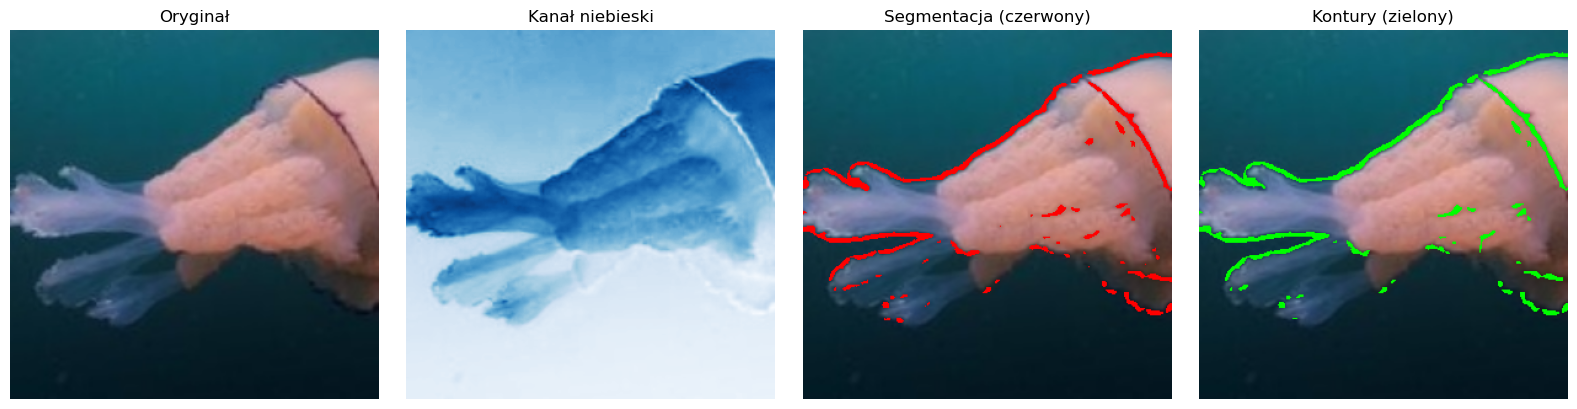


🔍 Gatunek: blue_jellyfish | Zdjęcie: 26.jpg


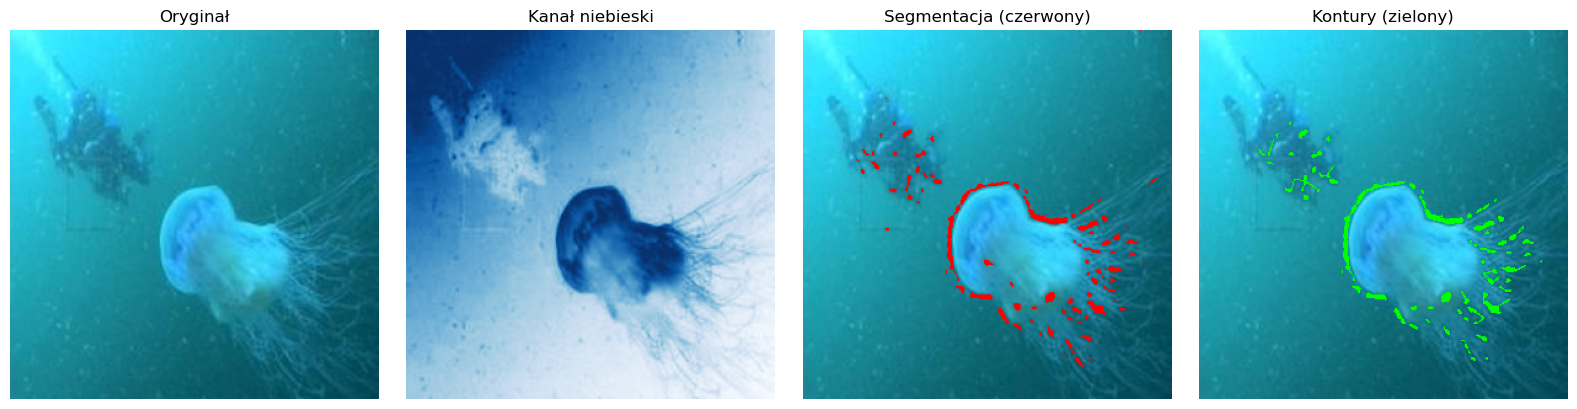


🔍 Gatunek: compass_jellyfish | Zdjęcie: 32.jpg


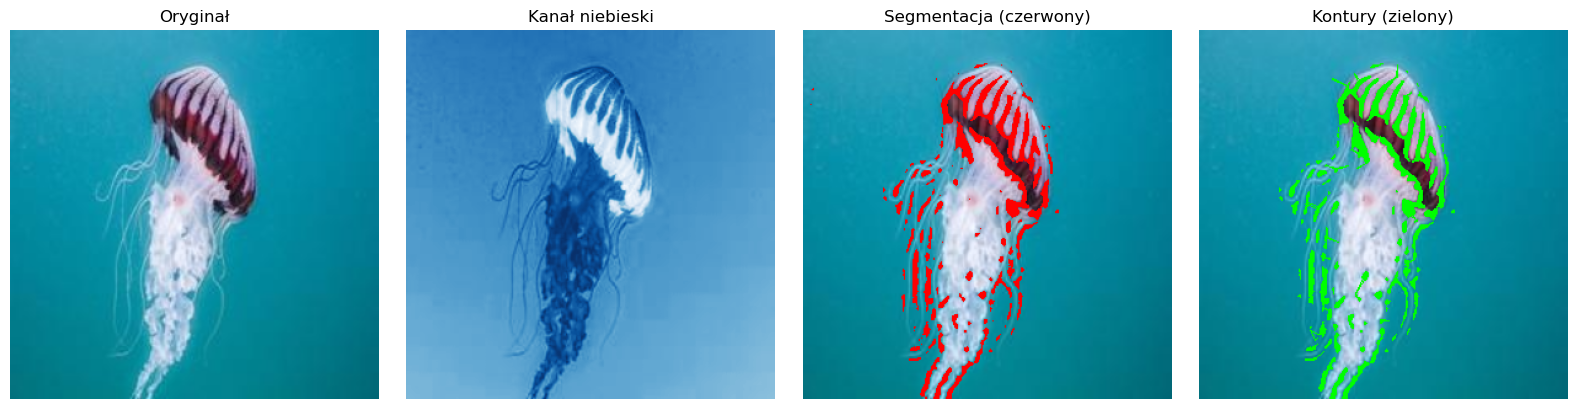


🔍 Gatunek: lions_mane_jellyfish | Zdjęcie: aug-47-60.jpg


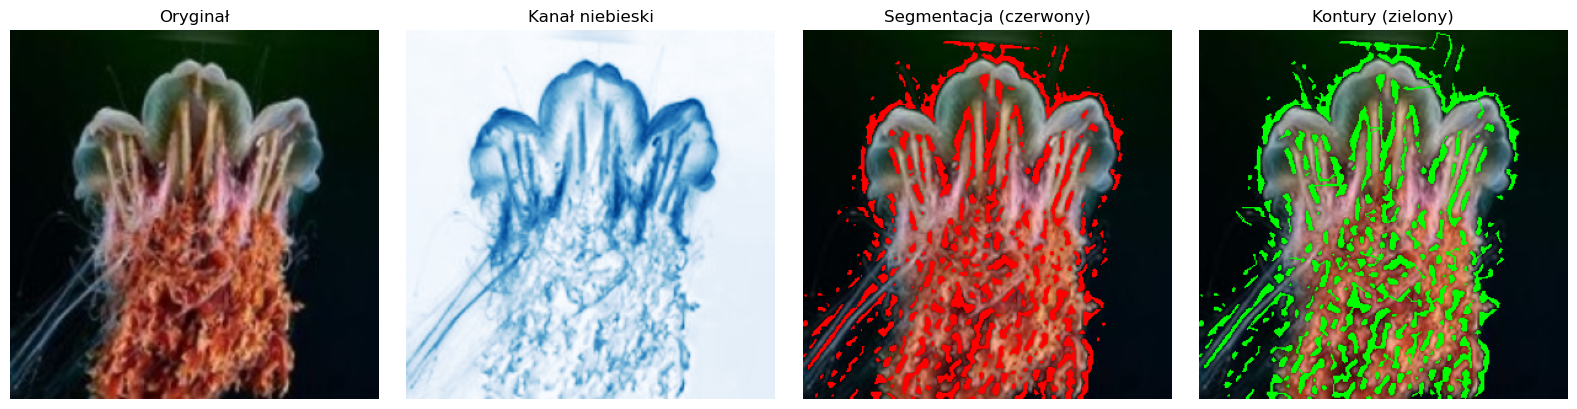


🔍 Gatunek: mauve_stinger_jellyfish | Zdjęcie: aug-48-58.jpg


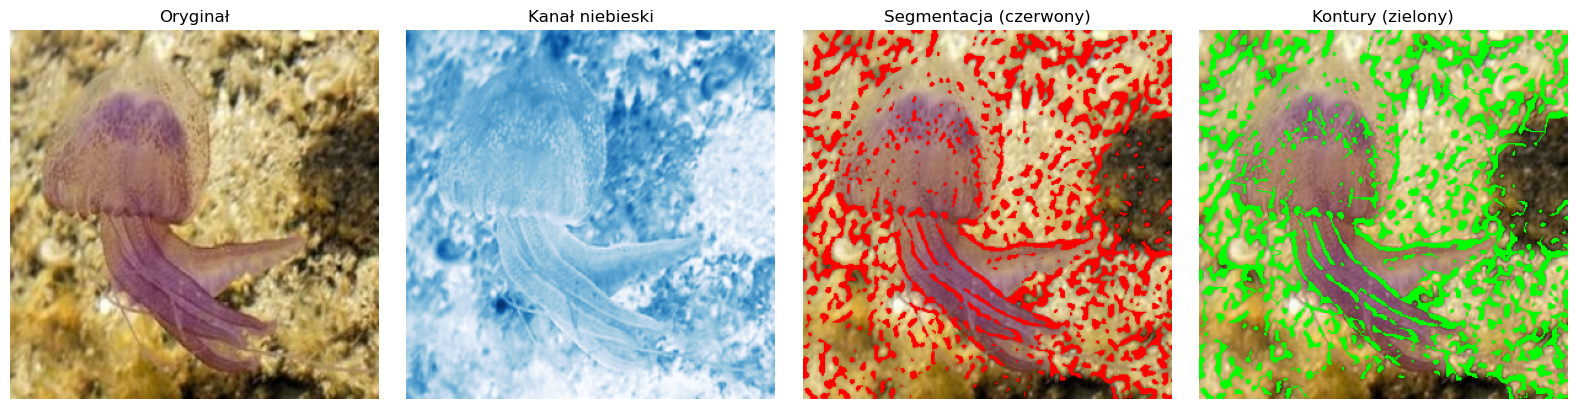


🔍 Gatunek: Moon_jellyfish | Zdjęcie: aug-37-50.jpg


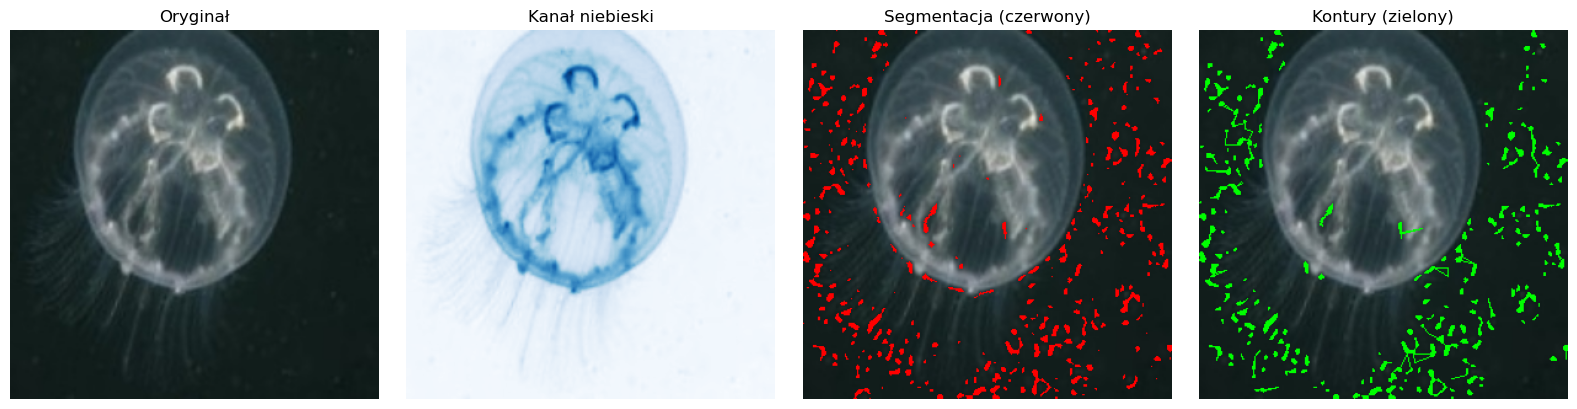

In [43]:
def segment_jellyfish_region_blue_channel(image_path):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (300, 300))

    # Zamiast skali szarości — użycie kanału niebieskiego
    blue_channel = img_resized[:, :, 0]
    equalized = cv2.equalizeHist(blue_channel)
    blurred = cv2.GaussianBlur(equalized, (9, 9), 0)

    # Adaptacyjne progowanie
    thresh = cv2.adaptiveThreshold(blurred, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV,
                                   11,6)

    # Podświetlenie detekcji na czerwono
    highlighted = img_resized.copy()
    highlighted[thresh > 0] = [0, 0, 255]

    # Dodatkowo: wyznaczenie punktów i konturów jak w Twoim kodzie
    points = np.column_stack(np.where(thresh > 0))
    points = [tuple(p[::-1]) for p in points]  # Zamiana z (y,x) na (x,y)

    # Połączenia punktów
    max_dist = 20
    groups = []
    visited = set()

    for i, pt in enumerate(points):
        if i in visited:
            continue
        group = [pt]
        visited.add(i)
        for j in range(i+1, len(points)):
            if j in visited:
                continue
            dist = np.linalg.norm(np.array(pt) - np.array(points[j]))
            if dist <= max_dist:
                group.append(points[j])
                visited.add(j)
        if len(group) >= 30:  # filtrujemy małe grupki
            groups.append(group)

    # Rysowanie linii między punktami
    contoured = img_resized.copy()
    for group in groups:
        for p in group:
            dists = [(np.linalg.norm(np.array(p) - np.array(q)), q) for q in group if p != q]
            dists.sort()
            for _, q in dists[:2]:  # tylko dwie najbliższe
                if np.linalg.norm(np.array(p) - np.array(q)) <= max_dist:
                    cv2.line(contoured, p, q, (0, 255, 0), 1)

    # Wizualizacja
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Oryginał")
    axs[1].imshow(blue_channel, cmap='Blues')
    axs[1].set_title("Kanał niebieski")
    axs[2].imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
    axs[2].set_title("Segmentacja (czerwony)")
    axs[3].imshow(cv2.cvtColor(contoured, cv2.COLOR_BGR2RGB))
    axs[3].set_title("Kontury (zielony)")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()



for species in jellyfish_species:
    species_dir = os.path.join(BASE_DIR, species)
    all_images = [f for f in os.listdir(species_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not all_images:
        print(f"⚠️ Brak zdjęć w folderze: {species}")
        continue
    
    image_filename = random.choice(all_images)
    image_path = os.path.join(species_dir, image_filename)

    print(f"\n🔍 Gatunek: {species} | Zdjęcie: {image_filename}")
    segment_jellyfish_region_blue_channel(image_path)
